<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/TIGER_%EB%AA%A8%EB%A9%98%ED%85%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install finance-datareader

In [ ]:
import pandas as pd
import FinanceDataReader as fdr
import re
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
etfs = fdr.StockListing('ETF/KR')

In [ ]:
rep_etfs = etfs[etfs['Name'].str.contains("TIGER", case=False)]
rep_etfs = rep_etfs[~rep_etfs['Name'].str.contains("레버리지|인버스|2X|커버드콜|혼합", case=False, regex=True)]


In [ ]:
import concurrent.futures

# ==============================
# 1. 기본 설정
# ==============================
symbols = rep_etfs['Symbol'].tolist()  # 대표 ETF 리스트

start_date = (datetime.datetime.today() - pd.DateOffset(months=120)).strftime('%Y-%m-%d')
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

# ==============================
# 2. 데이터 조회 함수 (월초/월말 포함)
# ==============================
def fetch_monthly_data(sym, start, end):
    try:
        df = fdr.DataReader(sym, start=start, end=end)[['Open', 'Close']]
        df_monthly = pd.DataFrame({
            f'{sym}_Open': df['Open'].resample('MS').first(),  # 월초 시가
            f'{sym}_Close': df['Close'].resample('ME').last()   # 월말 종가
        })
        return df_monthly
    except Exception as e:
        print(f"{sym} 조회 실패: {e}")
        return None

# ==============================
# 3. 병렬 처리
# ==============================
all_data_list = []

max_workers = 8  # CPU 코어 수나 네트워크 상황에 맞게 조절
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(fetch_monthly_data, sym, start_date, end_date): sym for sym in symbols}
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            all_data_list.append(result)

0043B0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0043B0?period1=1443139200&period2=1758758400&interval=1d&includeAdjustedClose=true
0052D0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0052D0?period1=1443139200&period2=1758758400&interval=1d&includeAdjustedClose=true
0072R0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0072R0?period1=1443139200&period2=1758758400&interval=1d&includeAdjustedClose=true
0094K0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0094K0?period1=1443139200&period2=1758758400&interval=1d&includeAdjustedClose=true
0047A0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v8/finance/chart/0047A0?period1=1443139200&period2=1758758400&interval=1d&includeAdjustedClose=true
0060H0 조회 실패: 404 Client Error: Not Found for url: https://query2.finance.yahoo.

In [ ]:
monthly_merged = pd.concat(all_data_list, axis=1)

# 월초 시가 / 월말 종가 분리
monthly_open = monthly_merged.filter(like='_Open').rename(columns=lambda x: x.replace('_Open',''))
monthly_close = monthly_merged.filter(like='_Close').rename(columns=lambda x: x.replace('_Close',''))

# 인덱스 변환 및 검증
monthly_open.index = pd.to_datetime(monthly_open.index, errors='coerce')
monthly_close.index = pd.to_datetime(monthly_close.index, errors='coerce')
assert monthly_open.index.equals(monthly_close.index), "Index mismatch between open and close"

In [ ]:
monthly_price = monthly_open.combine_first(monthly_close)


In [ ]:
# 월말 종가 데이터 추출
# monthly_price에서 월말 종가만 사용 (index가 월말인 행만 선택)
monthly_close_eom = monthly_price[monthly_price.index.is_month_end]
monthly_open_fom = monthly_price[monthly_price.index.is_month_start]

In [ ]:
import pandas as pd

def momentum_backtest(monthly_price, N_momentum=12, top_n=3):

    monthly_price = monthly_price.sort_index()

    # 월말 종가만 추출
    month_end = monthly_price.resample('M').last()

    # N개월 모멘텀 계산
    momentum = month_end.pct_change(N_momentum)

    results = []

    for i in range(N_momentum, len(month_end)-1):
        mom = momentum.iloc[i]
        top_symbols = mom.nlargest(top_n).index
        top_scores = mom[top_symbols]

        # 익월 월초~말일 수익률 계산
        next_month_idx = month_end.index[i+1]
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        next_month_end = month_end.iloc[i+1]

        returns = (next_month_end[top_symbols] - next_month_start[top_symbols]) / next_month_start[top_symbols]
        portfolio_return = returns.mean()

        results.append({
            'Month': next_month_idx.strftime('%Y-%m'),
            'Selected': list(top_symbols),
            'Momentum': list(top_scores.round(4)),
            'NextMonthReturn': list(returns.round(4)),
            'PortfolioReturn': round(portfolio_return, 4)
        })

    monthly_results = pd.DataFrame(results)
    cumulative_returns = (1 + monthly_results['PortfolioReturn']).cumprod()

    return monthly_results, cumulative_returns


     Month                                  Selected  \
0  2016-04  [227540, 139250, 143860, 138530, 182480]   
1  2016-05  [139240, 227540, 105010, 139250, 143860]   
2  2016-06  [139320, 105010, 227540, 182480, 139240]   
3  2016-07  [139320, 105010, 130680, 227540, 139230]   
4  2016-08  [105010, 139230, 091230, 182480, 139320]   

                                   Momentum  \
0   [0.3422, 0.2833, 0.2782, 0.1574, 0.139]   
1  [0.1609, 0.1497, 0.1352, 0.1289, 0.1206]   
2   [0.1395, 0.0804, 0.075, 0.0718, 0.0679]   
3  [0.2378, 0.1705, 0.1561, 0.1185, 0.1181]   
4  [0.3588, 0.3494, 0.2374, 0.2336, 0.2225]   

                                 NextMonthReturn  PortfolioReturn  
0  [-0.0423, -0.0715, -0.0526, -0.0372, -0.0101]          -0.0427  
1     [-0.1102, 0.0872, -0.0766, -0.0239, 0.043]          -0.0161  
2       [0.1044, 0.0423, 0.0256, 0.0559, -0.005]           0.0446  
3     [0.0187, 0.0398, -0.1209, -0.0799, 0.1306]          -0.0023  
4    [0.0444, 0.0719, -0.0318, -0.0391, 

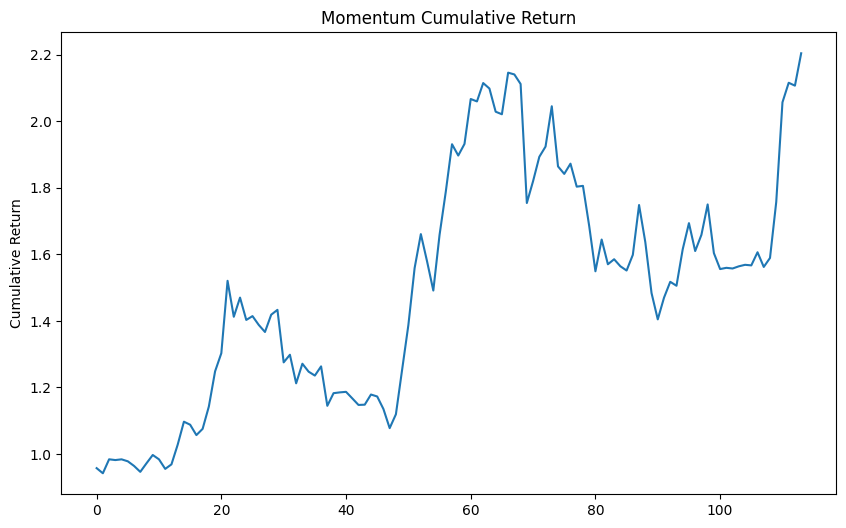

In [ ]:
monthly_results, cum_ret = momentum_backtest(
    monthly_price=monthly_price,
    N_momentum=6,
    top_n=5
)

# 결과 확인
print(monthly_results.head())

# 누적 수익률 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
cum_ret.plot(title="Momentum Cumulative Return")
plt.ylabel("Cumulative Return")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

def momentum_sweep_N_topn_top3_bottom3(monthly_price, N_list=range(3,13), top_n_list=range(3,8)):
    sweep_results = []
    cumulative_dict = {}

    # 모든 조합 백테스트
    for N, top_n in product(N_list, top_n_list):
        monthly_results, cum_ret = momentum_backtest(monthly_price, N_momentum=N, top_n=top_n)
        cumulative_dict[(N, top_n)] = cum_ret
        final_cum_ret = cum_ret.iloc[-1]
        sweep_results.append({'MomentumPeriod': N, 'TopN': top_n, 'FinalCumulativeReturn': final_cum_ret})

    sweep_results = pd.DataFrame(sweep_results)

    # 상위 3개, 하위 3개 조합 선택
    top3 = sweep_results.nlargest(3, 'FinalCumulativeReturn')
    bottom3 = sweep_results.nsmallest(3, 'FinalCumulativeReturn')
    selected_keys = list(top3[['MomentumPeriod','TopN']].itertuples(index=False, name=None)) + \
                    list(bottom3[['MomentumPeriod','TopN']].itertuples(index=False, name=None))

    # 그래프
    plt.figure(figsize=(12,6))
    for key in selected_keys:
        cum_ret = cumulative_dict[key]
        label = f'N={key[0]}, top_n={key[1]}'
        cum_ret.plot(label=label)
    plt.title('Top 3 & Bottom 3 Momentum Period & TopN Combinations')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

    return sweep_results, cumulative_dict

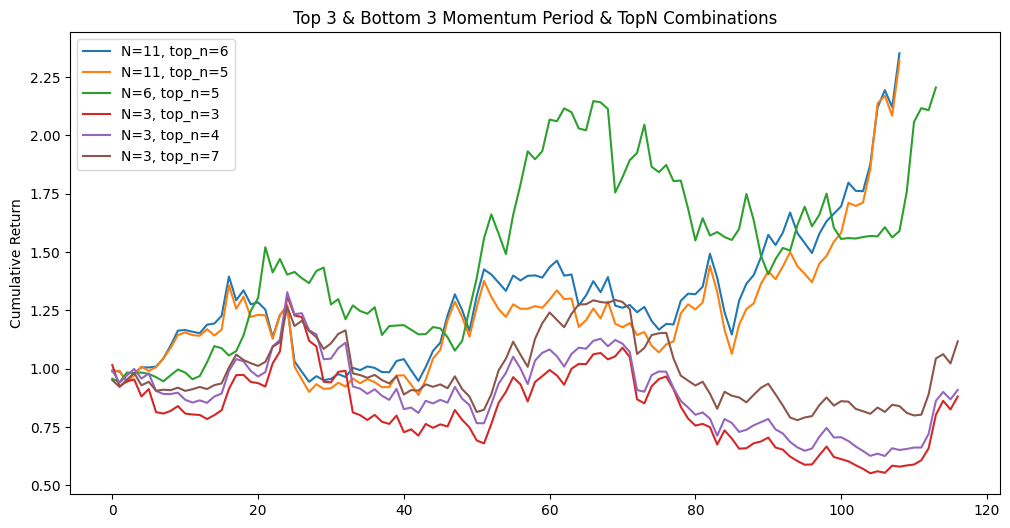

    MomentumPeriod  TopN  FinalCumulativeReturn
43              11     6               2.351404
42              11     5               2.317873
17               6     5               2.204963
16               6     4               2.125825
15               6     3               2.068380


In [ ]:
sweep_results, cumulative_dict = momentum_sweep_N_topn_top3_bottom3(
    monthly_price=monthly_price,
    N_list=range(3,13),
    top_n_list=range(3,8)
)

# 전체 조합 누적 수익률 결과
print(sweep_results.sort_values('FinalCumulativeReturn', ascending=False).head(5))

In [ ]:
# @title 검증용
def momentum_verification_table(monthly_price, N_momentum=12):
    """
    월말 종가 기준 N개월 모멘텀 점수와 익월 수익률 계산
    계산이 올바른지 검증할 수 있는 테이블 생성

    Parameters
    ----------
    monthly_price : pd.DataFrame
        날짜 인덱스, 종목코드 칼럼, 종가 데이터
    N_momentum : int
        모멘텀 계산 기간(개월)

    Returns
    -------
    verification_df : pd.DataFrame
        Month, Symbol, MomentumScore, NextMonthReturn, MomentumRank
    """
    monthly_price = monthly_price.sort_index()
    month_end = monthly_price.resample('M').last()
    momentum = month_end.pct_change(N_momentum)

    records = []

    for i in range(N_momentum, len(month_end)-1):
        mom = momentum.iloc[i]
        next_month_idx = month_end.index[i+1]
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0]
        next_month_end = month_end.iloc[i+1]
        next_month_ret = (next_month_end - next_month_start) / next_month_start

        # 모멘텀 순위
        mom_rank = mom.rank(ascending=False)

        for symbol in monthly_price.columns:
            records.append({
                'Month': next_month_idx.strftime('%Y-%m'),
                'Symbol': symbol,
                'MomentumScore': mom[symbol],
                'MomentumRank': mom_rank[symbol],
                'NextMonthReturn': next_month_ret[symbol]
            })

    verification_df = pd.DataFrame(records)

    return verification_df

verification_df = momentum_verification_table(monthly_price, N_momentum=8)


In [ ]:
import pandas as pd

def get_next_month_portfolio_with_names(monthly_price, etfs, reference_date, N_momentum=12, top_n=3):
    """
    조회 기준 월말 모멘텀으로 익월 포트폴리오 종목 및 이름 반환

    Parameters
    ----------
    monthly_price : pd.DataFrame
        날짜 인덱스, 종목코드 칼럼, 종가 데이터
    etfs : pd.DataFrame
        Symbol, Name 컬럼 포함 ETF 정보
    reference_date : str or pd.Timestamp
        조회 기준 날짜 (예: '2025-08-31')
    N_momentum : int
        모멘텀 계산 기간(개월)
    top_n : int
        상위 N개 종목 선정

    Returns
    -------
    pd.DataFrame
        Symbol, Name 컬럼 포함 익월 포트폴리오 종목
    """
    monthly_price = monthly_price.sort_index()
    month_end = monthly_price.resample('M').last()

    reference_date = pd.to_datetime(reference_date)
    month_key = month_end.index[month_end.index <= reference_date][-1]

    # 모멘텀 계산
    if month_end.index.get_loc(month_key) < N_momentum:
        raise ValueError(f"N_momentum={N_momentum}개월 모멘텀 계산 불가. 데이터 부족")

    mom = (month_end.loc[month_key] - month_end.iloc[month_end.index.get_loc(month_key)-N_momentum]) / \
          month_end.iloc[month_end.index.get_loc(month_key)-N_momentum]

    # 상위 N개 종목 선정
    top_symbols = mom.nlargest(top_n).index.tolist()

    # Symbol → Name 매칭
    top_df = etfs[etfs['Symbol'].isin(top_symbols)].copy()
    top_df = top_df.set_index('Symbol').loc[top_symbols].reset_index()  # 원래 순서 유지

    return top_df


In [ ]:
top_df = get_next_month_portfolio_with_names(monthly_price, etfs, reference_date='2025-05-31', N_momentum=6, top_n=5)
top_df


,Symbol,Category,Name,Price,RiseFall,Change,ChangeRate,NAV,EarningRate,Volume,Amount,MarCap
0,463250,2,TIGER K방산&우주,32585,5,-180,-0.55,32599.0,8.6733,859986,28496,3128
1,494670,2,TIGER 조선TOP10,25420,2,30,0.12,25437.0,15.2519,2086655,53788,6457
2,139230,2,TIGER 200 중공업,12385,5,-165,-1.31,12392.0,9.7027,1269455,15920,3017
3,228790,2,TIGER 화장품,3850,5,-40,-1.03,3852.0,-4.7736,3820945,14733,3206
4,139220,2,TIGER 200 건설,4210,5,-40,-0.94,4212.0,-6.4907,210497,888,352


In [ ]:

def evaluate_momentum_strategy(monthly_price, N_momentum=12, top_n=3, risk_free_rate=0.0):

    # ======================
    # 1. 월말 기준 포트폴리오 수익률 계산
    # ======================
    monthly_price = monthly_price.sort_index()
    month_end = monthly_price.resample('M').last()
    results = []

    for i in range(N_momentum, len(month_end)-1):
        ref_month = month_end.index[i]
        next_month_idx = month_end.index[i+1]

        # 모멘텀 계산
        mom = (month_end.loc[ref_month] - month_end.iloc[i-N_momentum]) / month_end.iloc[i-N_momentum]

        # 상위 N개 종목 선정
        top_symbols = mom.nlargest(top_n).index
        next_month_start = monthly_price.loc[monthly_price.index >= next_month_idx.replace(day=1)].iloc[0][top_symbols]
        next_month_end = month_end.loc[next_month_idx][top_symbols]
        returns = (next_month_end - next_month_start) / next_month_start
        portfolio_return = returns.mean()

        results.append({
            'Month': next_month_idx,
            'PortfolioReturn': portfolio_return
        })

    df_results = pd.DataFrame(results).set_index('Month')
    df_results['CumulativeReturn'] = (1 + df_results['PortfolioReturn']).cumprod()

    # ======================
    # 2. 성과 지표 계산
    # ======================
    total_months = len(df_results)
    years = total_months / 12
    cumulative_return = df_results['CumulativeReturn'].iloc[-1]
    annual_return = cumulative_return**(1/years) - 1
    annual_vol = df_results['PortfolioReturn'].std() * (12**0.5)
    running_max = df_results['CumulativeReturn'].cummax()
    drawdown = (df_results['CumulativeReturn'] - running_max) / running_max
    max_drawdown = drawdown.min()
    sharpe = (annual_return - risk_free_rate) / annual_vol

    metrics = {
        'AnnualizedReturn': annual_return,
        'AnnualVolatility': annual_vol,
        'MaxDrawdown': max_drawdown,
        'SharpeRatio': sharpe
    }

    # ======================
    # 3. 누적 수익률 시각화
    # ======================
    plt.figure(figsize=(10,6))
    plt.plot(df_results['CumulativeReturn'], label='Momentum Portfolio', linewidth=2)
    plt.title('Cumulative Return of Momentum Portfolio')
    plt.xlabel('Month')
    plt.ylabel('Cumulative Return')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return df_results, metrics

In [ ]:
df_results, metrics = evaluate_momentum_strategy(monthly_price, N_momentum=11, top_n=6)

print("월별 포트폴리오 수익률:")
print(df_results.head())

print("\n전략 성과 지표:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")